# Normalizing flows: binary classification

## Load packages

In [ ]:
using Random
using LinearAlgebra
using PyPlot
using Distributions
using BenchmarkTools
using ProgressMeter
using Optim
using Revise

using ReactiveMP
using GraphPPL
using Rocket;

## Generate data

In [2]:
function generate_data(nr_samples::Int64)

    # sample weights
    w = rand(nr_samples,2)

    # sample appraisal
    y = zeros(Float64, nr_samples)
    for k = 1:nr_samples
        y[k] = 1.0*(w[k,1] > 0.5)*(w[k,2] < 0.5)
    end

    # return data
    return y, w

end;

In [3]:
data_y, data_x = generate_data(200);

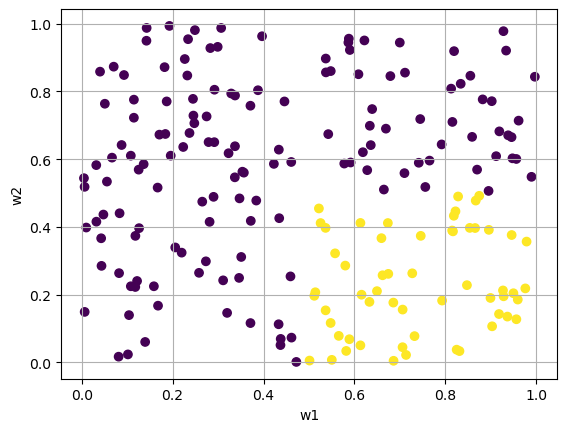

In [4]:
plt.scatter(data_x[:,1], data_x[:,2], c=data_y)
plt.grid()
plt.xlabel("w1")
plt.ylabel("w2");

## Model specification

In [5]:
@model function flow_classifier(nr_samples::Int64, params)
    
    # initialize variables
    x_lat  = randomvar(nr_samples)
    y_lat1 = randomvar(nr_samples)
    y_lat2 = randomvar(nr_samples)
    y      = datavar(Float64, nr_samples)
    x      = datavar(Vector{Float64}, nr_samples)

    # specify model
    model = FlowModel( (NiceLayer(         PlanarMap(params[1],  params[2],  params[3])),
                        ReverseNiceLayer(  PlanarMap(params[4],  params[5],  params[6])),
                        NiceLayer(         PlanarMap(params[7],  params[8],  params[9])),
                        ReverseNiceLayer(  PlanarMap(params[10], params[11], params[12]))))
    meta  = FlowMeta(model)

    # specify observations
    for k = 1:nr_samples

        # specify latent state
        x_lat[k] ~ MvNormalMeanPrecision(x[k], 1e3*diagm(ones(2)))

        # specify transformed latent value
        y_lat1[k] ~ Flow(x_lat[k]) where { meta = meta }
        y_lat2[k] ~ dot(y_lat1[k], [1, 1])

        # specify observations
        y[k] ~ Probit(y_lat2[k]) # default: where { pipeline = RequireInbound(in = NormalMeanPrecision(0, 1.0)) }

    end

    # return variables
    return x_lat, x, y_lat1, y_lat2, y

end;

## Probabilistic Inference

In [6]:
function inference_flow_classifier(data_y::Array{Float64,1}, data_x::Array{Array{Float64,1},1}, params)
    
    # fetch number of samples
    nr_samples = length(data_y)

    # define model
    model, (x_lat, x, y_lat1, y_lat2, y) = flow_classifier(nr_samples, params)

    # initialize free energy
    fe_buffer = nothing
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (fe) -> fe_buffer = fe)

    # update y and x according to observations (i.e. perform inference)
    ReactiveMP.update!(y, data_y)
    ReactiveMP.update!(x, data_x)

    # unsubscribe
    unsubscribe!(fe_sub)
    
    # return the marginal values
    return fe_buffer

end;

In [7]:
function f(params)
    fe = inference_flow_classifier(data_y, [data_x[k,:] for k=1:size(data_x,1)], params)
    return fe
end;

## Experimental validation

In [34]:
res = optimize(f, randn(12), LBFGS(), Optim.Options(g_tol = 1e-3, iterations = 100, store_trace = true, show_trace = true), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     1.739352e+03     1.097760e+03
 * time: 0.0
     1     5.174823e+02     8.076174e+02
 * time: 0.3230001926422119
     2     1.070939e+02     9.743545e+01
 * time: 0.45200014114379883
     3     8.036876e+01     4.697518e+01
 * time: 0.6230001449584961
     4     7.174315e+01     5.066158e+01
 * time: 0.8420000076293945
     5     6.241424e+01     2.009686e+01
 * time: 1.0429999828338623
     6     5.987550e+01     1.611130e+01
 * time: 1.2410001754760742
     7     5.824257e+01     1.556125e+01
 * time: 1.4539999961853027
     8     5.694392e+01     3.775505e+01
 * time: 1.636000156402588
     9     5.586189e+01     4.775549e+00
 * time: 1.8410000801086426
    10     5.553463e+01     2.743234e+01
 * time: 1.999000072479248
    11     5.476240e+01     2.583213e+01
 * time: 2.1630001068115234
    12     5.144330e+01     2.996677e+01
 * time: 2.383000135421753
    13     5.003661e+01     8.050586e+01
 * time: 2.563000202178955
    14     

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     3.603303e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 4.88e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.38e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.37e-02 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.57e-03 ≰ 0.0e+00
    |g(x)|                 = 9.52e+01 ≰ 1.0e-03

 * Work counters
    Seconds run:   17  (vs limit Inf)
    Iterations:    100
    f(x) calls:    271
    ∇f(x) calls:   271


In [35]:
function uniformpdf(y; xmin = 0, xmax = 1, ymin = 0, ymax = 1)
    indomain = 1.0*(xmin <= y[1] <= xmax)*(ymin <= y[2] <= ymax)
    return indomain/(xmax-xmin)/(ymax-ymin)
end

uniformpdf (generic function with 1 method)

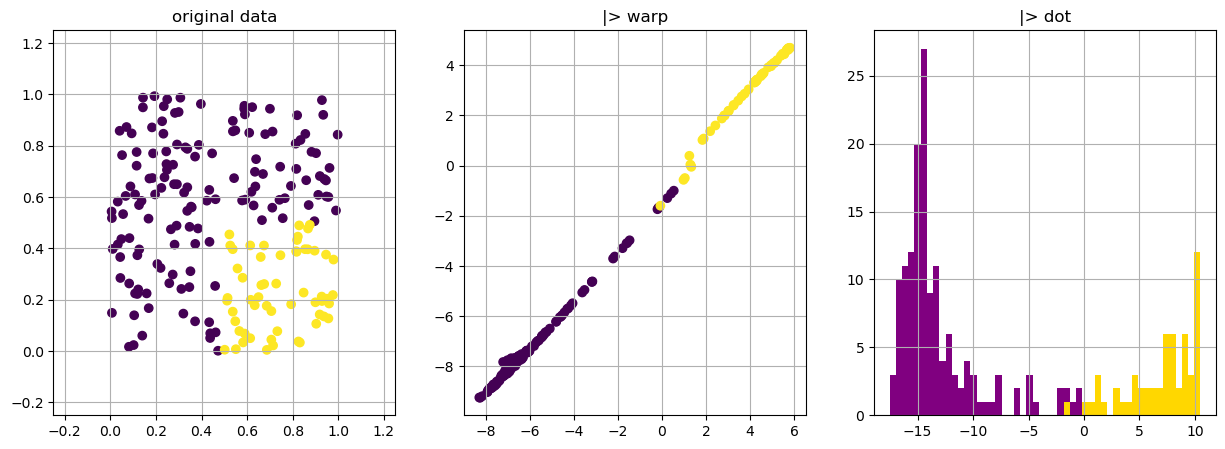

In [36]:
params = Optim.minimizer(res)
inferred_model = FlowModel( (NiceLayer(         PlanarMap(params[1],  params[2],  params[3])),
                             ReverseNiceLayer(  PlanarMap(params[4],  params[5],  params[6])),
                             NiceLayer(         PlanarMap(params[7],  params[8],  params[9])),
                             ReverseNiceLayer(  PlanarMap(params[10], params[11], params[12]))))
trans_data_x_1 = hcat(map((x) -> forward(inferred_model, x), [data_x[k,:] for k=1:size(data_x,1)])...)'
trans_data_x_2 = map((x) -> dot([1, 1], x), [trans_data_x_1[k,:] for k=1:size(data_x,1)])
trans_data_x_2_split = [trans_data_x_2[data_y .== 1.0], trans_data_x_2[data_y .== 0.0]]
fig, ax = plt.subplots(ncols = 3, figsize=(15,5))
ax[1].scatter(data_x[:,1], data_x[:,2], c = data_y)
ax[2].scatter(trans_data_x_1[:,1], trans_data_x_1[:,2], c = data_y)
ax[3].hist(trans_data_x_2_split; stacked=true, bins=50, color = ["gold", "purple"])
ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[1].set_xlim(-0.25,1.25), ax[1].set_ylim(-0.25,1.25)
ax[1].set_title("original data"), ax[2].set_title("|> warp"), ax[3].set_title("|> dot");

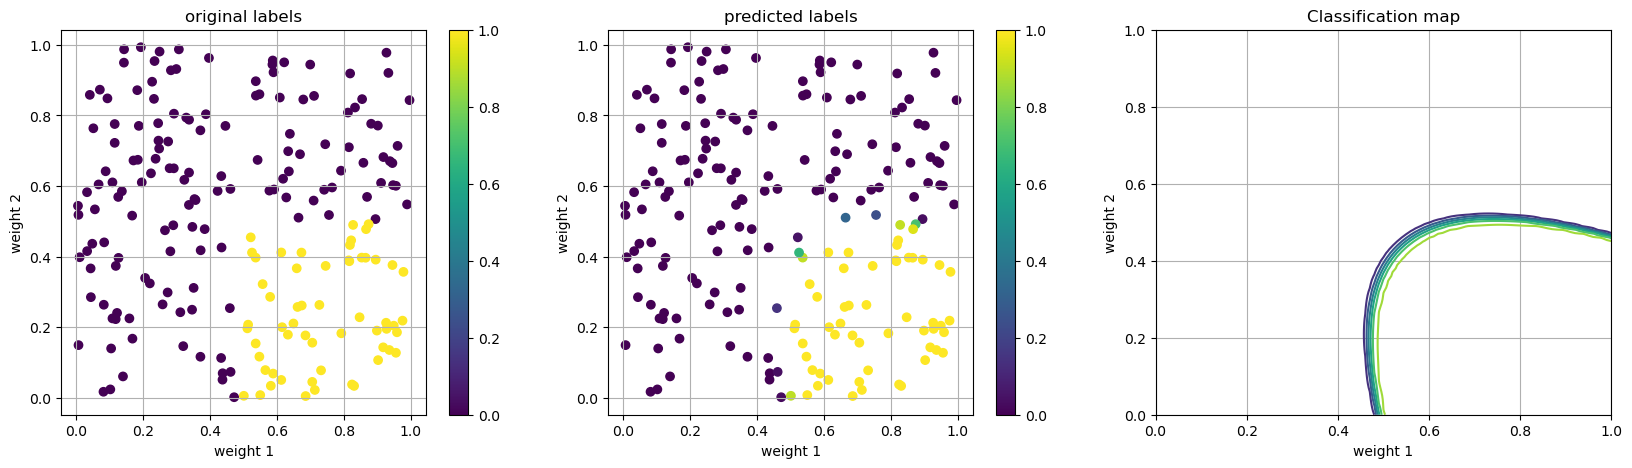

In [37]:
using StatsFuns: normcdf
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1))))
fig, ax = plt.subplots(ncols = 3, figsize=(20,5))
im1 = ax[1].scatter(data_x[:,1], data_x[:,2], c = data_y)
im2 = ax[2].scatter(data_x[:,1], data_x[:,2], c = normcdf.(trans_data_x_2))
ax[3].contour(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])
ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[1].set_xlabel("weight 1"), ax[1].set_ylabel("weight 2"), ax[2].set_xlabel("weight 1"), ax[2].set_ylabel("weight 2"), ax[3].set_xlabel("weight 1"), ax[3].set_ylabel("weight 2")
ax[1].set_title("original labels"), ax[2].set_title("predicted labels"), ax[3].set_title("Classification map");